In [21]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Figure 1 - Dimensionality vs. encoding performance

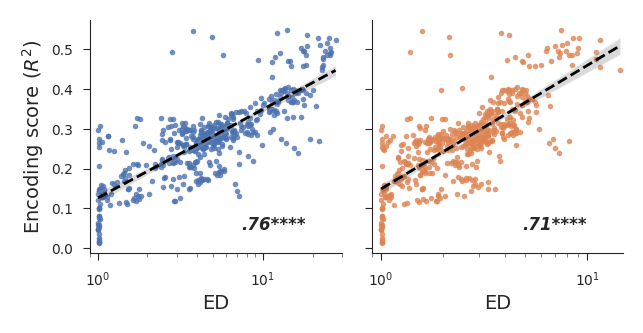

In [46]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.55))

axs[0].set_xlim(0.9, 30)
sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0])
axs[0].set(xlabel='ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.6, 0.1), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True, color=sns.color_palette()[1],
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[1])
axs[1].set(xlabel='ED', ylabel=None, yticklabels=[], xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.6, 0.1), ax=axs[1])

plt.savefig('saved/results_01_ED.png', dpi=300)
plt.show()

---
# Figure 1 - Dimensionality vs. encoding performance by layer

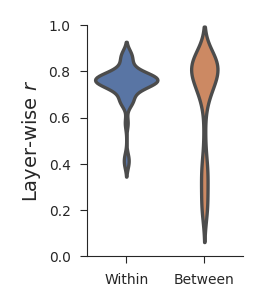

In [23]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.2, 1.42))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', inner=None, ax=ax)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', 
       xticklabels=['Within', 'Between'], ylim=(0, 1))

plt.savefig('saved/results_01_layerwise.png', dpi=300)
plt.show()

---
# Figure 2 - Dimensionality vs. layer depth

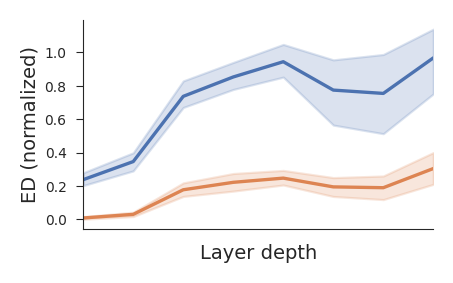

In [24]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.kind != 'Untrained') & (data.architecture == 'ResNet18')]

normed_metrics = data.groupby(['architecture', 'task', 'kind', 'source'])\
                     [['between-concept dimensionality', 'within-concept dimensionality (mean)']]\
                     .apply(lambda x: (x - x.min().min()) / (x.max().max() - x.min().max()))
normed_metrics.columns = [c + ' normed' for c in normed_metrics.columns]
data = pd.concat([data, normed_metrics], axis=1)

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean) normed', 'between-concept dimensionality normed'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.15, 1.3))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED (normalized)', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

ax.legend().remove()

plt.savefig('saved/results_02_depth.png', dpi=300)
plt.show()

---
# Figure 2 - Training

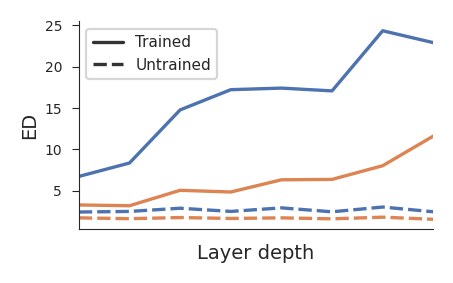

In [25]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.source == 'PyTorch') & (data.architecture == 'ResNet18')]

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.15, 1.3))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', style='kind',
             style_order=['Supervised', 'Untrained'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

handles, _ = ax.get_legend_handles_labels()
ax.legend(loc='upper left', 
          labels=['Trained', 'Untrained'], 
          handles=handles[4:6])

plt.savefig('saved/results_02_training.png', dpi=300)
plt.show()

---
# Figure 3 - Classification

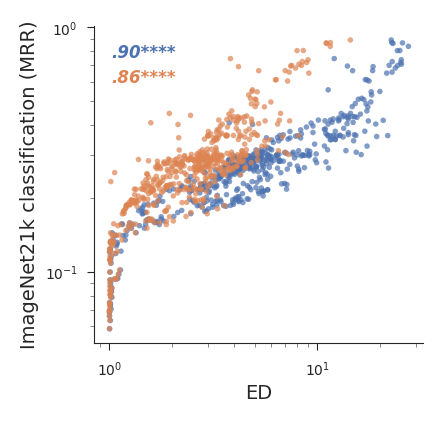

In [63]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet'
data = pd.merge(data, 
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data.melt(id_vars=id_columns + ['MRR'], 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='metric_value', y='MRR', hue='metric',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='ED', ylabel='ImageNet21k classification (MRR)')
annotate_corr(data[data.metric == 'within-concept dimensionality (mean)'], 
              x='metric_value', y='MRR', ax=ax, 
              pos=(0.05, 0.9), color=sns.color_palette()[0])
annotate_corr(data[data.metric == 'between-concept dimensionality'], 
              x='metric_value', y='MRR', ax=ax, 
              pos=(0.05, 0.82), color=sns.color_palette()[1])

ax.legend().remove()

plt.savefig('saved/results_03_classification.png', dpi=300)
plt.show()

In [31]:
# data = pd.DataFrame()
# for d, c in [('imagenet', 'linear'), ('imagenet', 'prototype'), 
#              ('imagenet21k', 'linear'), ('imagenet21k', 'prototype')]:
#     data_i = pd.read_csv(f'../../results/n-shot|dataset:{d}|classifier:{c}|pooling:True.csv')
#     data_i = data_i[data_i.n_train == 50]
#     data_i = data_i.drop([c for c in data_i.columns if c not in id_columns + ['MRR']], axis='columns')
#     data_i = data_i.groupby(id_columns, as_index=False).mean()
#     data_i = data_i.assign(classifier=c, dataset_nshot=d)
#     data = data.append(data_i)
# del data_i

# dataset = 'imagenet'
# data = pd.merge(data, 
#                 pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
#                 on=id_columns)
# data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
# data = data.melt(id_vars=id_columns + ['MRR', 'classifier', 'dataset_nshot'], 
#                  value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
#                  var_name='metric', value_name='metric_value')

# g = sns.lmplot(data=data, x='metric_value', y='MRR', hue='metric', col='classifier', row='dataset_nshot',
#                col_order=['prototype', 'linear'], row_order=['imagenet21k', 'imagenet'],
#                scatter_kws={'alpha': 0.5, 's': .5}, sharex=True, sharey=True, 
#                height=1.5, aspect=.9, fit_reg=False, legend=False)

# for ax in g.axes.flatten():
#     ax.set(xscale='log', yscale='log')
# for row, c in zip(range(g.axes.shape[0]), ['Prototype', 'Linear']):
#     for col, d in zip(range(g.axes.shape[1]), ['ImageNet21k', 'ImageNet']):
#         g.axes[row, col].set(title=f'{c}-{d}', xlabel='ED' if row == 1 else None)
#         annotate_corr(data[(data.classifier == c.lower()) & 
#                            (data.dataset_nshot == d.lower()) & 
#                            (data.metric == 'within-concept dimensionality (mean)')], 
#                       x='metric_value', y='MRR', 
#                       ax=g.axes[row, col], 
#                       pos=(0.6, 0.2), color=sns.color_palette()[0])
#         annotate_corr(data[(data.classifier == c.lower()) & 
#                            (data.dataset_nshot == d.lower()) & 
#                            (data.metric == 'between-concept dimensionality')], 
#                       x='metric_value', y='MRR', 
#                       ax=g.axes[row, col], 
#                       pos=(0.6, 0.1), color=sns.color_palette()[1])

# plt.subplots_adjust(hspace=.4, left=0.15, right=.98, bottom=0.11, top=.93)
# plt.savefig('saved/results_03_classification.png', dpi=300)
# plt.show()